In [9]:
import os
import pickle
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_pickle_files(folder_path):
    """
    Get all the .pickle files from a folder.

    Args:
    - folder_path (str): Path to the folder containing .pickle files

    Returns:
    - List of .pickle files
    """
    pickle_files = [file for file in os.listdir(folder_path) if file.endswith('.pickle')]
    return pickle_files

In [3]:
def convert_to_3d_tensors(radar_return):
    """
    Convert radar_return values to 3D torch tensors.

    Args:
    - radar_return (ndarray): 2D matrix consisting of complex numbers

    Returns:
    - 3D torch tensor with shape (width, height, channels)
    """
    real_part = radar_return.real
    imag_part = radar_return.imag
    # Convert NumPy arrays to PyTorch tensors
    array = np.stack((real_part, imag_part), axis=0)
    return array

In [4]:
def process_pickle_files(folder_path):
    """
    Process all .pickle files in a folder.

    Args:
    - folder_path (str): Path to the folder containing .pickle files

    Returns:
    - DataFrame containing all the samples
    """
    # Get .pickle files
    pickle_files = get_pickle_files(folder_path)
    dataframes = []
    for file_name in pickle_files:
        with open(os.path.join(folder_path, file_name), 'rb') as f:
            file_data = pickle.load(f)
            radar_return = file_data['radar_return']
            object_id = file_data['object_id']
            concatenated_radar = convert_to_3d_tensors(radar_return).astype('float32')
            # Create a DataFrame with concatenated radar and object_id
            df = pd.DataFrame({'radar_return': [concatenated_radar], 'object_id': [object_id]})
            # Append the DataFrame to the list
            dataframes.append(df)

    # Concatenate the list of DataFrames into a single DataFrame
    df = pd.concat(dataframes, ignore_index=True)
    return df

In [5]:
# Example usage
folder_path = 'Overfit_data'
df = process_pickle_files(folder_path)

In [14]:
# Access a specific row (e.g., the first row)
sample_row = df.iloc[2]

# Access the 'radar_return' column of the sample row
sample_image = sample_row['radar_return']

# Display shape and values
print("Shape of the sample image:", sample_image.shape)
print("Sample image values:")
print(sample_image)

Shape of the sample image: (2, 108, 50)
Sample image values:
[[[1.3630228e-03 6.9898058e-04 8.8521733e-04 ... 6.0069751e-06
   7.9557240e-06 0.0000000e+00]
  [1.3540494e-03 7.0099538e-04 8.8623224e-04 ... 5.7911434e-06
   8.9290361e-06 0.0000000e+00]
  [1.3693771e-03 6.9884409e-04 8.9456886e-04 ... 9.8729406e-06
   1.1725869e-05 0.0000000e+00]
  ...
  [1.9968518e-05 2.4618219e-06 5.2131745e-06 ... 1.0604719e-03
   1.7985321e-03 0.0000000e+00]
  [7.0221413e-06 1.1079486e-05 1.4272417e-06 ... 9.9194248e-04
   1.8057893e-03 0.0000000e+00]
  [2.6426924e-06 7.6188203e-06 2.6058683e-06 ... 9.4395078e-04
   1.7787950e-03 0.0000000e+00]]

 [[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  ...
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.00

In [15]:

def plot_channels(tensor):
    """
    Plot each channel of a 3D tensor as grayscale images.

    Args:
    - tensor (ndarray): 3D numpy array with shape (channels, height, width)
    """
    num_channels = tensor.shape[0]
    fig, axes = plt.subplots(1, num_channels, figsize=(5*num_channels, 5))
    
    for i in range(num_channels):
        ax = axes[i] if num_channels > 1 else axes
        ax.imshow(tensor[i], cmap='gray')
        ax.set_title(f'Channel {i+1}')
        ax.axis('off')
    
    plt.show()


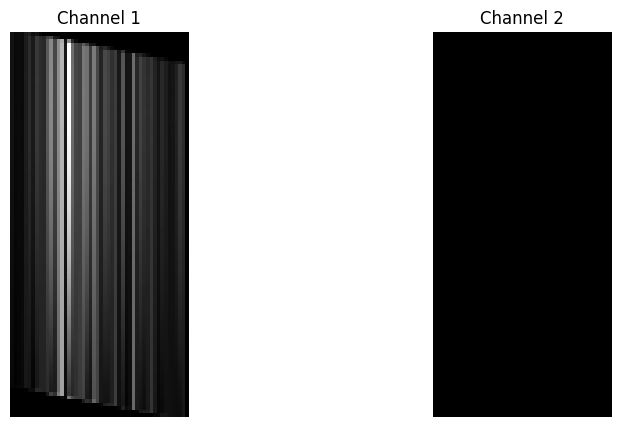

In [16]:
plot_channels(sample_image)